In [255]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

from sklearn.metrics import mean_squared_error

## Read in data

In [310]:
train = pd.read_csv('train_to_model.csv')

In [311]:
train.head()

,Unnamed: 0,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Year,Month,Day,Promo2New,StateHolidayBool
0,0,1,5,2015-07-31,5263,555,1,nh,1,c,1,1270,2015,7,31,0,0
1,1,2,5,2015-07-31,6064,625,1,nh,1,a,1,570,2015,7,31,1,0
2,2,3,5,2015-07-31,8314,821,1,nh,1,a,1,14130,2015,7,31,1,0
3,3,4,5,2015-07-31,13995,1498,1,nh,1,c,3,620,2015,7,31,0,0
4,4,5,5,2015-07-31,4822,559,1,nh,1,a,1,29910,2015,7,31,0,0


In [312]:
train.dtypes

Unnamed: 0              int64
Store                   int64
DayOfWeek               int64
Date                   object
Sales                   int64
Customers               int64
Promo                   int64
StateHoliday           object
SchoolHoliday           int64
StoreType              object
Assortment              int64
CompetitionDistance     int64
Year                    int64
Month                   int64
Day                     int64
Promo2New               int64
StateHolidayBool        int64
dtype: object

In [313]:
train = train.drop(train.columns[[0, 5, 16]], axis=1)

In [314]:
train.dtypes

Store                   int64
DayOfWeek               int64
Date                   object
Sales                   int64
Promo                   int64
StateHoliday           object
SchoolHoliday           int64
StoreType              object
Assortment              int64
CompetitionDistance     int64
Year                    int64
Month                   int64
Day                     int64
Promo2New               int64
dtype: object

## Split into Test / Train dataframes

### Format Date and set as index

In [315]:
train['Date'] = pd.to_datetime(train['Date'])

In [316]:
train.dtypes

Store                           int64
DayOfWeek                       int64
Date                   datetime64[ns]
Sales                           int64
Promo                           int64
StateHoliday                   object
SchoolHoliday                   int64
StoreType                      object
Assortment                      int64
CompetitionDistance             int64
Year                            int64
Month                           int64
Day                             int64
Promo2New                       int64
dtype: object

In [317]:
train.set_index('Date', inplace=True)

In [319]:
train.head()

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Year,Month,Day,Promo2New
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,1,nh,1,c,1,1270,2015,7,31,0
2015-07-31,2,5,6064,1,nh,1,a,1,570,2015,7,31,1
2015-07-31,3,5,8314,1,nh,1,a,1,14130,2015,7,31,1
2015-07-31,4,5,13995,1,nh,1,c,3,620,2015,7,31,0
2015-07-31,5,5,4822,1,nh,1,a,1,29910,2015,7,31,0


In [320]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 844392 entries, 2015-07-31 to 2013-01-01
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Store                844392 non-null  int64 
 1   DayOfWeek            844392 non-null  int64 
 2   Sales                844392 non-null  int64 
 3   Promo                844392 non-null  int64 
 4   StateHoliday         844392 non-null  object
 5   SchoolHoliday        844392 non-null  int64 
 6   StoreType            844392 non-null  object
 7   Assortment           844392 non-null  int64 
 8   CompetitionDistance  844392 non-null  int64 
 9   Year                 844392 non-null  int64 
 10  Month                844392 non-null  int64 
 11  Day                  844392 non-null  int64 
 12  Promo2New            844392 non-null  int64 
dtypes: int64(11), object(2)
memory usage: 90.2+ MB


In [321]:
# save csv of full train df ready for test
train.to_csv('train_for_test.csv')

### Use timeseries to split data

In [12]:
# estimate sales from 2015-08-01 to 2015-09-17

In [13]:
# sort df by date
train.sort_index(inplace=True)

In [14]:
train

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Year,Month,Day,Promo2New
Date,,,,,,,,,,,,,
2013-01-01,1097,2,5961,0,a,1,b,2,720,2013,1,1,0
2013-01-01,85,2,4220,0,a,1,b,1,1870,2013,1,1,0
2013-01-01,259,2,6851,0,a,1,b,2,210,2013,1,1,0
2013-01-01,262,2,17267,0,a,1,b,1,1180,2013,1,1,0
2013-01-01,274,2,3102,0,a,1,b,2,3640,2013,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,745,5,8363,1,nh,1,a,1,17650,2015,7,31,1
2015-07-31,746,5,9082,1,nh,1,d,3,4330,2015,7,31,1
2015-07-31,747,5,10708,1,nh,1,c,3,45740,2015,7,31,0


In [ ]:
X = train.drop(columns=['Sales'])
y = train['Sales']

In [16]:
tss = TimeSeriesSplit(n_splits=2)

In [17]:
for train_index, val_index in tss.split(X):
    X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 562928 entries, 2013-01-01 to 2014-09-12
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Store                562928 non-null  int64 
 1   DayOfWeek            562928 non-null  int64 
 2   Promo                562928 non-null  int64 
 3   StateHoliday         562928 non-null  object
 4   SchoolHoliday        562928 non-null  int64 
 5   StoreType            562928 non-null  object
 6   Assortment           562928 non-null  int64 
 7   CompetitionDistance  562928 non-null  int64 
 8   Year                 562928 non-null  int64 
 9   Month                562928 non-null  int64 
 10  Day                  562928 non-null  int64 
 11  Promo2New            562928 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 55.8+ MB


In [19]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 281464 entries, 2014-09-12 to 2015-07-31
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Store                281464 non-null  int64 
 1   DayOfWeek            281464 non-null  int64 
 2   Promo                281464 non-null  int64 
 3   StateHoliday         281464 non-null  object
 4   SchoolHoliday        281464 non-null  int64 
 5   StoreType            281464 non-null  object
 6   Assortment           281464 non-null  int64 
 7   CompetitionDistance  281464 non-null  int64 
 8   Year                 281464 non-null  int64 
 9   Month                281464 non-null  int64 
 10  Day                  281464 non-null  int64 
 11  Promo2New            281464 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 27.9+ MB


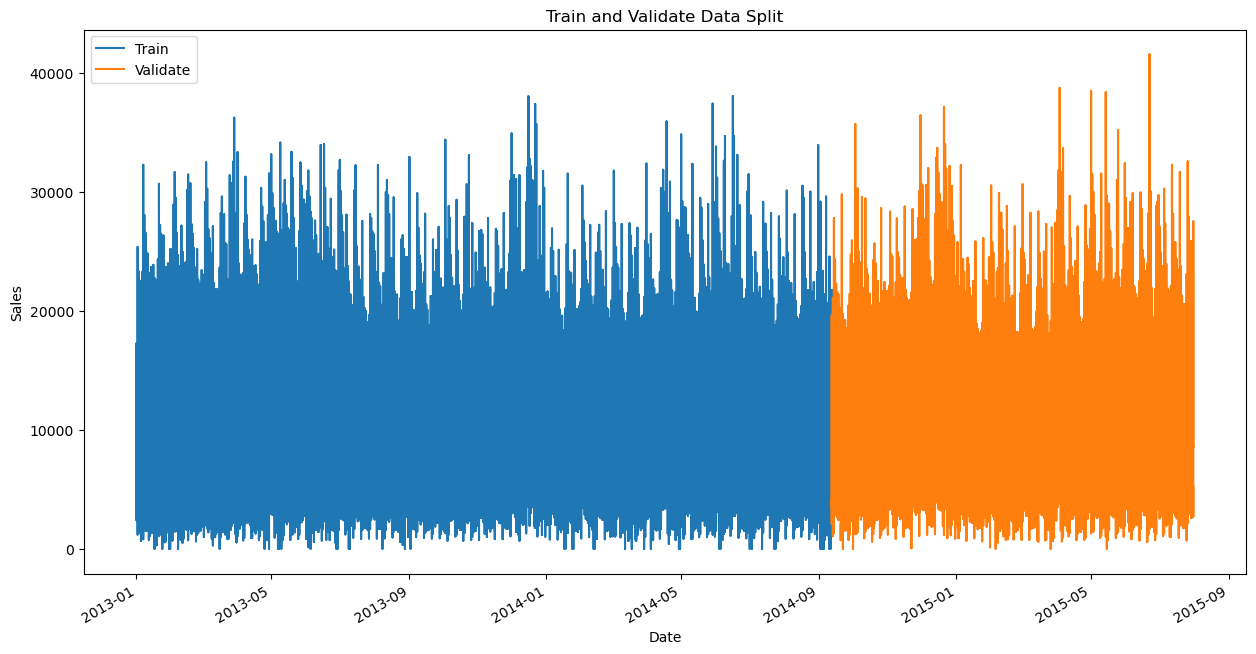

In [20]:
plt.figure(figsize=(15,8))
ax = y_train.plot()
y_val.plot(ax=ax)
plt.legend(['Train', 'Validate'])
plt.title('Train and Validate Data Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [21]:
y_train.shape

(562928,)

In [22]:
y_val.shape

(281464,)

In [23]:
y_train = np.array(y_train).reshape(-1,1)
y_train.shape

(562928, 1)

In [24]:
y_val = np.array(y_val).reshape(-1,1)
y_val.shape

(281464, 1)

## Transformation

In [25]:
X_train['Assortment'].value_counts()

Assortment
1    297396
3    260115
2      5417
Name: count, dtype: int64

In [26]:
# transformer to covert categorical variables 
cat_transformer_onehot = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore', 
                                                                            sparse=False))])

# set order of values for ordinal variable
cat_transformer_ordinal = Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(categories=[[1, 2, 3]]))])


# transformer to move towards normal distribution of numerical variables
num = Pipeline(steps=[('encoder', PowerTransformer())])      

In [27]:
# classify columns for transformation
preprocessor  = ColumnTransformer(remainder='passthrough', transformers = [
    ('cat', cat_transformer_onehot, 
     ['StateHoliday', 'StoreType']), 
    ('ordinal', cat_transformer_ordinal,
     ['Assortment']),
    ('num', num,
     ['CompetitionDistance'])
])

In [28]:
# transform the data
pipeline = Pipeline(steps=[("preprocessor", preprocessor)])
# fit the transformer to X_train
pipe_fit = pipeline.fit(X_train)

X_train_tf = pd.DataFrame(pipe_fit.transform(X_train), columns = pipe_fit.get_feature_names_out().tolist())
X_train_tf.info()

/Users/gysd/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562928 entries, 0 to 562927
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   cat__StateHoliday_a       562928 non-null  float64
 1   cat__StateHoliday_b       562928 non-null  float64
 2   cat__StateHoliday_c       562928 non-null  float64
 3   cat__StateHoliday_nh      562928 non-null  float64
 4   cat__StoreType_a          562928 non-null  float64
 5   cat__StoreType_b          562928 non-null  float64
 6   cat__StoreType_c          562928 non-null  float64
 7   cat__StoreType_d          562928 non-null  float64
 8   ordinal__Assortment       562928 non-null  float64
 9   num__CompetitionDistance  562928 non-null  float64
 10  remainder__Store          562928 non-null  float64
 11  remainder__DayOfWeek      562928 non-null  float64
 12  remainder__Promo          562928 non-null  float64
 13  remainder__SchoolHoliday  562928 non-null  f

In [29]:
X_train_tf.head()

,cat__StateHoliday_a,cat__StateHoliday_b,cat__StateHoliday_c,cat__StateHoliday_nh,cat__StoreType_a,cat__StoreType_b,cat__StoreType_c,cat__StoreType_d,ordinal__Assortment,num__CompetitionDistance,remainder__Store,remainder__DayOfWeek,remainder__Promo,remainder__SchoolHoliday,remainder__Year,remainder__Month,remainder__Day,remainder__Promo2New
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.724838,1097.0,2.0,0.0,1.0,2013.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.154736,85.0,2.0,0.0,1.0,2013.0,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.369193,259.0,2.0,0.0,1.0,2013.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.437994,262.0,2.0,0.0,1.0,2013.0,1.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.283967,274.0,2.0,0.0,1.0,2013.0,1.0,1.0,0.0


In [30]:
X_train_tf['ordinal__Assortment'].value_counts()

ordinal__Assortment
0.0    297396
2.0    260115
1.0      5417
Name: count, dtype: int64

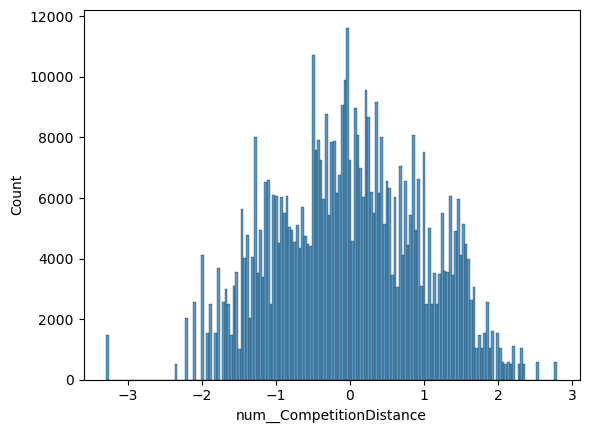

In [31]:
# distribution of competition distance
sns.histplot(data=X_train_tf, x='num__CompetitionDistance');

In [32]:
X_val_tf = pd.DataFrame(pipe_fit.transform(X_val), columns = pipe_fit.get_feature_names_out().tolist())
X_val_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281464 entries, 0 to 281463
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   cat__StateHoliday_a       281464 non-null  float64
 1   cat__StateHoliday_b       281464 non-null  float64
 2   cat__StateHoliday_c       281464 non-null  float64
 3   cat__StateHoliday_nh      281464 non-null  float64
 4   cat__StoreType_a          281464 non-null  float64
 5   cat__StoreType_b          281464 non-null  float64
 6   cat__StoreType_c          281464 non-null  float64
 7   cat__StoreType_d          281464 non-null  float64
 8   ordinal__Assortment       281464 non-null  float64
 9   num__CompetitionDistance  281464 non-null  float64
 10  remainder__Store          281464 non-null  float64
 11  remainder__DayOfWeek      281464 non-null  float64
 12  remainder__Promo          281464 non-null  float64
 13  remainder__SchoolHoliday  281464 non-null  f

In [33]:
X_train_tf.describe()

,cat__StateHoliday_a,cat__StateHoliday_b,cat__StateHoliday_c,cat__StateHoliday_nh,cat__StoreType_a,cat__StoreType_b,cat__StoreType_c,cat__StoreType_d,ordinal__Assortment,num__CompetitionDistance,remainder__Store,remainder__DayOfWeek,remainder__Promo,remainder__SchoolHoliday,remainder__Year,remainder__Month,remainder__Day,remainder__Promo2New
count,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000,5.629280e+05,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000,562928.000000
mean,0.000803,0.000171,0.000064,0.998963,0.540543,0.018098,0.133072,0.308286,0.933773,-1.261785e-16,558.076003,3.526499,0.433903,0.208609,2013.399669,5.751952,15.642983,0.402771
std,0.028325,0.013058,0.007997,0.032193,0.498354,0.133307,0.339653,0.461786,0.992972,1.000001e+00,321.669253,1.723873,0.495612,0.406315,0.489831,3.210084,8.714435,0.490456
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.288238e+00,1.000000,1.000000,0.000000,0.000000,2013.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.327106e-01,280.000000,2.000000,0.000000,0.000000,2013.000000,3.000000,8.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.655462e-02,557.000000,4.000000,0.000000,0.000000,2013.000000,6.000000,15.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,7.375968e-01,837.000000,5.000000,1.000000,0.000000,2014.000000,8.000000,23.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.798179e+00,1115.000000,7.000000,1.000000,1.000000,2014.000000,12.000000,31.000000,1.000000


## Modelling

### Create RMSPE function

In [86]:
def rmspe(y_true, y_pred):
    
    # Ensure inputs are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Check if arrays have the same shape
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape.")
    
    # Avoid division by zero
    mask = y_true != 0
    
    # Calculate % error
    #p_error = np.where(mask, (y_true - y_pred) / y_true, 0)
    p_error = np.where(y_true != 0, (y_true - y_pred) / np.where(y_true != 0, y_true, 1), 0)
    
    # square % error
    s_p_error = p_error **2
    
    # calculate mean of SPE
    msp_error = np.mean(s_p_error)
    
    # calculate sqrt of mspe
    rmspe = np.sqrt(msp_error)
    
    return rmspe

## Try models

### Linear regression

In [35]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_tf, y_train)

LinearRegression()

In [36]:
LR_predictions = linear_regression.predict(X_val_tf)
LR_predictions.shape

(281464, 1)

In [37]:
LR_predictions_reshaped = LR_predictions.ravel()
LR_predictions_reshaped

array([6032.47070312, 6302.96875   , 6172.97460938, ..., 8271.40039062,
       8594.56835938, 8267.24804688])

In [38]:
y_val_reshaped = y_val.ravel()
y_val_reshaped.shape

(281464,)

In [39]:
LR_df = pd.DataFrame({'Predicted Sales' : LR_predictions_reshaped, 'Actual Sales' : y_val_reshaped})

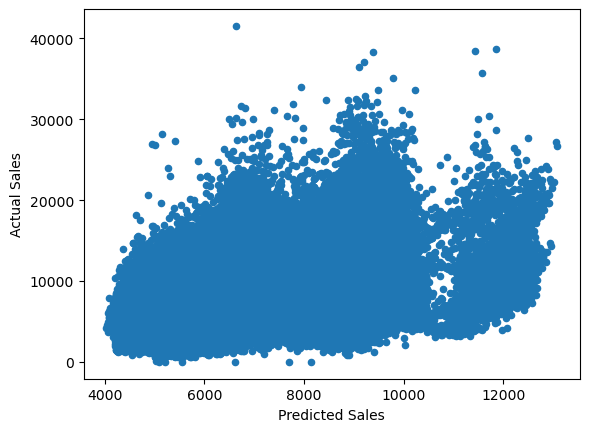

In [40]:
LR_df.plot('Predicted Sales', 'Actual Sales', kind='scatter');

In [41]:
LR_rmse = mean_squared_error(LR_predictions_reshaped, y_val_reshaped, squared=False)
LR_rmspe = rmspe(y_val_reshaped, LR_predictions_reshaped)

/var/folders/fp/_jk7rzqj00756q1bhvwhswcw0000gp/T/ipykernel_6979/333079173.py:15: RuntimeWarning: divide by zero encountered in divide
  p_error = np.where(mask, (y_true - y_pred) / y_true, 0)


In [42]:
print('Linear Regression model RMSE: ', LR_rmse)
print('Linear Regression model RMSPE: ', LR_rmspe)

Linear Regression model RMSE:  2798.494295549755
Linear Regression model RMSPE:  0.53738803180897


### Decision Tree Regression

In [43]:
decision_tree_model = DecisionTreeRegressor(random_state=42)

In [44]:
decision_tree_model.fit(X_train_tf, y_train)

DecisionTreeRegressor(random_state=42)

In [45]:
DT_predictions = decision_tree_model.predict(X_val_tf)
DT_predictions

array([ 4563.,  5458.,  4213., ...,  9567., 11302.,  5572.])

In [46]:
DT_df = pd.DataFrame({'Predicted Sales' : DT_predictions, 'Actual Sales' : y_val_reshaped})

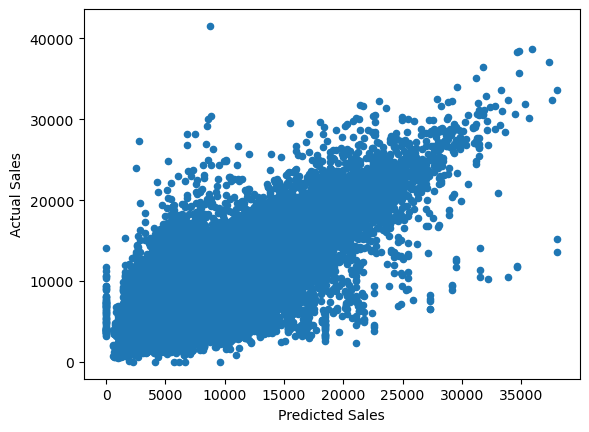

In [47]:
DT_df.plot('Predicted Sales', 'Actual Sales', kind='scatter');

In [48]:
DT_rmse = mean_squared_error(DT_predictions, y_val_reshaped, squared=False)
DT_rmspe = rmspe(y_val_reshaped, DT_predictions)

/var/folders/fp/_jk7rzqj00756q1bhvwhswcw0000gp/T/ipykernel_6979/333079173.py:15: RuntimeWarning: divide by zero encountered in divide
  p_error = np.where(mask, (y_true - y_pred) / y_true, 0)


In [49]:
print('Decision Tree Regression model RMSE: ', DT_rmse)
print('Decision Tree Regression model RMSPE: ', DT_rmspe)

Decision Tree Regression model RMSE:  1601.6239448695046
Decision Tree Regression model RMSPE:  0.2872470516586516


### Random Forest

In [51]:
y_train_reshaped = y_train.ravel()

In [50]:
random_forest_model = RandomForestRegressor(random_state=42, n_jobs=-1)

In [158]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [159]:
rf_grid_search = GridSearchCV(estimator=random_forest_model, param_grid=rf_param_grid, scoring='neg_mean_squared_error', cv=5)

In [160]:
for params in tqdm(rf_grid_search.param_grid):
    rf_grid_search.fit(X_train_tf, y_train_reshaped)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [3:37:42<00:00, 4354.10s/it]


In [162]:
rf_params = rf_grid_search.best_params_
rf_params

{'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}

In [163]:
random_forest_model = RandomForestRegressor(random_state=42, n_jobs=-1, **rf_params)

In [164]:
random_forest_model.fit(X_train_tf, y_train_reshaped)

RandomForestRegressor(min_samples_split=5, n_estimators=300, n_jobs=-1,
                      random_state=42)

In [165]:
RF_predictions = random_forest_model.predict(X_val_tf)
RF_predictions

array([ 4309.77505087,  5319.84228836,  4243.81887542, ...,
       10132.61606097, 10664.13726503,  6056.89346898])

In [166]:
RF_df = pd.DataFrame({'Predicted Sales' : RF_predictions, 'Actual Sales' : y_val_reshaped})

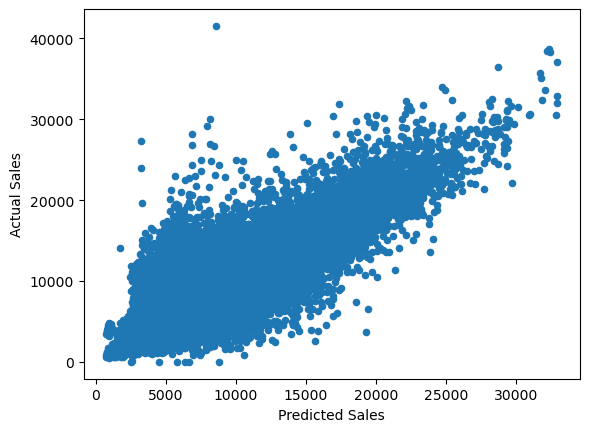

In [167]:
RF_df.plot('Predicted Sales', 'Actual Sales', kind='scatter');

In [168]:
RF_rmse = mean_squared_error(RF_predictions, y_val_reshaped, squared=False)
RF_rmspe = rmspe(y_val_reshaped,RF_predictions)

In [169]:
print('Random Forest Regression model RMSE: ', RF_rmse)
print('Random Forest Regression model RMSPE: ', RF_rmspe)

Random Forest Regression model RMSE:  1312.1324009856269
Random Forest Regression model RMSPE:  0.263882497589032


#### Feature Importance

In [171]:
rf_feature_importance_df = pd.DataFrame({
    'Feature' : X_train_tf.columns,
    'Importance' : random_forest_model.feature_importances_
}).sort_values('Importance', ascending=False)

In [172]:
rf_feature_importance_df

,Feature,Importance
10,remainder__Store,0.299677
9,num__CompetitionDistance,0.270748
12,remainder__Promo,0.141340
11,remainder__DayOfWeek,0.069870
16,remainder__Day,0.045262
15,remainder__Month,0.043581
8,ordinal__Assortment,0.031167
5,cat__StoreType_b,0.024349
17,remainder__Promo2New,0.016843
4,cat__StoreType_a,0.016809


### XGBoost

In [118]:
XGB_model = xgb.XGBRegressor(random_state=42)

Tuning parameters:
max_depth (of a tree; default 6) - increasing depth can result in better predictions as the model becomes more complex, but also increases risk of overfitting, so offset by eta. 
eta is the learning rate (default 0.3) - smaller steps result in slower learning and better generalisability, while larger steps result in faster learning but an increased risk of overfitting. 

In [132]:
# range of hyperparameters
xgb_param_grid = {
    'eta': [0.1, 0.2],
    'max_depth': [6, 8, 10],
    'gamma': [0, 1, 2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

In [133]:
# Perform grid search cross-validation
xgb_grid_search = GridSearchCV(estimator=XGB_model, param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=5)

In [134]:
for params in tqdm(xgb_grid_search.param_grid):
    xgb_grid_search.fit(X_train_tf, y_train)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [1:28:45<00:00, 1065.00s/it]


In [135]:
xgb_params = xgb_grid_search.best_params_
xgb_params

{'colsample_bytree': 0.8,
 'eta': 0.2,
 'gamma': 1,
 'max_depth': 10,
 'subsample': 0.6}

In [259]:
# tune parameters 
xgb_final_params = {"booster": "gbtree", 'objective':'reg:squarederror', **xgb_params}

In [297]:
XGB_model = xgb.XGBRegressor(random_state=42, **xgb_final_params)

In [298]:
XGB_model.fit(X_train_tf, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.2, eval_metric=None,
             feature_types=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [299]:
XGB_predictions = XGB_model.predict(X_val_tf)
XGB_predictions

array([ 3948.5186,  5202.7993,  3784.131 , ..., 10872.781 , 10059.812 ,
        5925.0024], dtype=float32)

In [300]:
XGB_df = pd.DataFrame({'Predicted Sales' : XGB_predictions, 'Actual Sales' : y_val_reshaped})

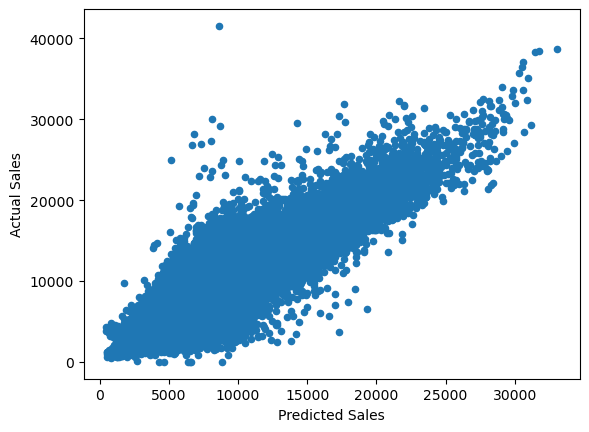

In [301]:
XGB_df.plot('Predicted Sales', 'Actual Sales', kind='scatter');

In [302]:
XGB_rmse = mean_squared_error(XGB_predictions, y_val_reshaped, squared=False)
XGB_rmspe = rmspe(y_val_reshaped,XGB_predictions)

In [303]:
print('XGBoost model RMSE: ', XGB_rmse)
print('XGBoost model RMSPE: ', XGB_rmspe)

XGBoost model RMSE:  1221.7740172474214
XGBoost model RMSPE:  0.25692995305540617


In [304]:
xgb_feature_importance_df = pd.DataFrame({
    'Feature' : X_train_tf.columns,
    'Importance' : XGB_model.feature_importances_
}).sort_values('Importance', ascending=False)

In [305]:
xgb_feature_importance_df

,Feature,Importance
12,remainder__Promo,0.206231
5,cat__StoreType_b,0.174198
9,num__CompetitionDistance,0.117437
10,remainder__Store,0.101396
8,ordinal__Assortment,0.063894
7,cat__StoreType_d,0.060879
6,cat__StoreType_c,0.060036
17,remainder__Promo2New,0.052460
4,cat__StoreType_a,0.044718
11,remainder__DayOfWeek,0.032683


## Results

### Error Metric

In [306]:
pd.Series({'Linear Regression RMSPE': LR_rmspe,
               'Decision Tree RMSPE': DT_rmspe,
               'Random Forest RMSPE': RF_rmspe,
               'XGBoost RMSPE' : XGB_rmspe
              })

Linear Regression RMSPE    0.537388
Decision Tree RMSPE        0.287247
Random Forest RMSPE        0.263882
XGBoost RMSPE              0.256930
dtype: float64

### Visualisation

In [193]:
LR_predictions_reshaped

array([6032.47070312, 6302.96875   , 6172.97460938, ..., 8271.40039062,
       8594.56835938, 8267.24804688])

In [184]:
DT_predictions

array([ 4563.,  5458.,  4213., ...,  9567., 11302.,  5572.])

In [185]:
RF_predictions

array([ 4309.77505087,  5319.84228836,  4243.81887542, ...,
       10132.61606097, 10664.13726503,  6056.89346898])

In [186]:
XGB_predictions

array([ 3948.5186,  5202.7993,  3784.131 , ..., 10872.781 , 10059.812 ,
        5925.0024], dtype=float32)

In [201]:
results = train.copy()

In [202]:
results

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Year,Month,Day,Promo2New
Date,,,,,,,,,,,,,
2013-01-01,1097,2,5961,0,a,1,b,2,720,2013,1,1,0
2013-01-01,85,2,4220,0,a,1,b,1,1870,2013,1,1,0
2013-01-01,259,2,6851,0,a,1,b,2,210,2013,1,1,0
2013-01-01,262,2,17267,0,a,1,b,1,1180,2013,1,1,0
2013-01-01,274,2,3102,0,a,1,b,2,3640,2013,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,745,5,8363,1,nh,1,a,1,17650,2015,7,31,1
2015-07-31,746,5,9082,1,nh,1,d,3,4330,2015,7,31,1
2015-07-31,747,5,10708,1,nh,1,c,3,45740,2015,7,31,0


In [194]:
null_val_len = len(results) - len(LR_predictions_reshaped)
null_val_len

562928

In [191]:
null_values_array = np.full(null_val_len, np.nan)
null_values_array

array([nan, nan, nan, ..., nan, nan, nan])

In [195]:
LR_predictions_merge = np.concatenate((null_values_array, LR_predictions_reshaped))
LR_predictions_merge

array([          nan,           nan,           nan, ..., 8271.40039062,
       8594.56835938, 8267.24804688])

In [198]:
DT_predictions_merge = np.concatenate((null_values_array, DT_predictions))
DT_predictions_merge

array([   nan,    nan,    nan, ...,  9567., 11302.,  5572.])

In [199]:
RF_predictions_merge = np.concatenate((null_values_array, RF_predictions))
RF_predictions_merge

array([           nan,            nan,            nan, ...,
       10132.61606097, 10664.13726503,  6056.89346898])

In [200]:
XGB_predictions_merge = np.concatenate((null_values_array, XGB_predictions))
XGB_predictions_merge

array([           nan,            nan,            nan, ...,
       10872.78125   , 10059.81152344,  5925.00244141])

In [203]:
results['LR_predictions'] = LR_predictions_merge
results['DT_predictions'] = DT_predictions_merge
results['RF_predictions'] = RF_predictions_merge
results['XGB_predictions'] = XGB_predictions_merge

results

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Year,Month,Day,Promo2New,LR_predictions,DT_predictions,RF_predictions,XGB_predictions
Date,,,,,,,,,,,,,,,,,
2013-01-01,1097,2,5961,0,a,1,b,2,720,2013,1,1,0,NaN,NaN,NaN,NaN
2013-01-01,85,2,4220,0,a,1,b,1,1870,2013,1,1,0,NaN,NaN,NaN,NaN
2013-01-01,259,2,6851,0,a,1,b,2,210,2013,1,1,0,NaN,NaN,NaN,NaN
2013-01-01,262,2,17267,0,a,1,b,1,1180,2013,1,1,0,NaN,NaN,NaN,NaN
2013-01-01,274,2,3102,0,a,1,b,2,3640,2013,1,1,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-31,745,5,8363,1,nh,1,a,1,17650,2015,7,31,1,7029.921875,9486.0,9739.951464,9524.066406
2015-07-31,746,5,9082,1,nh,1,d,3,4330,2015,7,31,1,8006.230469,7157.0,7986.886752,8457.685547
2015-07-31,747,5,10708,1,nh,1,c,3,45740,2015,7,31,0,8271.400391,9567.0,10132.616061,10872.781250


In [206]:
results_sales = results[['Sales', 'LR_predictions', 'DT_predictions', 'RF_predictions', 'XGB_predictions']]
results_sales

,Sales,LR_predictions,DT_predictions,RF_predictions,XGB_predictions
Date,,,,,
2013-01-01,5961,NaN,NaN,NaN,NaN
2013-01-01,4220,NaN,NaN,NaN,NaN
2013-01-01,6851,NaN,NaN,NaN,NaN
2013-01-01,17267,NaN,NaN,NaN,NaN
2013-01-01,3102,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2015-07-31,8363,7029.921875,9486.0,9739.951464,9524.066406
2015-07-31,9082,8006.230469,7157.0,7986.886752,8457.685547
2015-07-31,10708,8271.400391,9567.0,10132.616061,10872.781250


In [220]:
results_sales.loc[:, results_sales.columns] = results_sales.loc[:, results_sales.columns].apply(pd.to_numeric, errors='coerce')

In [224]:
mean_results = results_sales.groupby(results_sales.index).mean()
mean_results

,Sales,LR_predictions,DT_predictions,RF_predictions,XGB_predictions
Date,,,,,
2013-01-01,5719.705882,NaN,NaN,NaN,NaN
2013-01-02,6255.471647,NaN,NaN,NaN,NaN
2013-01-03,5723.913436,NaN,NaN,NaN,NaN
2013-01-04,5991.835740,NaN,NaN,NaN,NaN
2013-01-05,5376.326107,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2015-07-27,9620.208446,8799.797730,9105.973944,9281.106129,9116.188176
2015-07-28,8189.643306,8652.612174,7776.733154,7886.907142,7780.505125
2015-07-29,7636.982929,8505.424674,7514.692722,7695.532273,7609.627645


In [230]:
val_results = mean_results.loc[mean_results['LR_predictions'] >= 0]
val_results

,Sales,LR_predictions,DT_predictions,RF_predictions,XGB_predictions
Date,,,,,
2014-09-12,5879.600858,6071.698607,6008.617174,6053.163776,5937.954768
2014-09-13,5509.194206,5912.456893,5479.166309,5441.549918,5422.048332
2014-09-14,7856.225806,7506.815902,7694.806452,7632.495937,7609.607879
2014-09-15,9360.877682,8814.286891,9838.786481,9854.882127,9542.456895
2014-09-16,7715.809013,8667.101391,8351.745708,8418.009798,8336.144381
...,...,...,...,...,...
2015-07-27,9620.208446,8799.797730,9105.973944,9281.106129,9116.188176
2015-07-28,8189.643306,8652.612174,7776.733154,7886.907142,7780.505125
2015-07-29,7636.982929,8505.424674,7514.692722,7695.532273,7609.627645


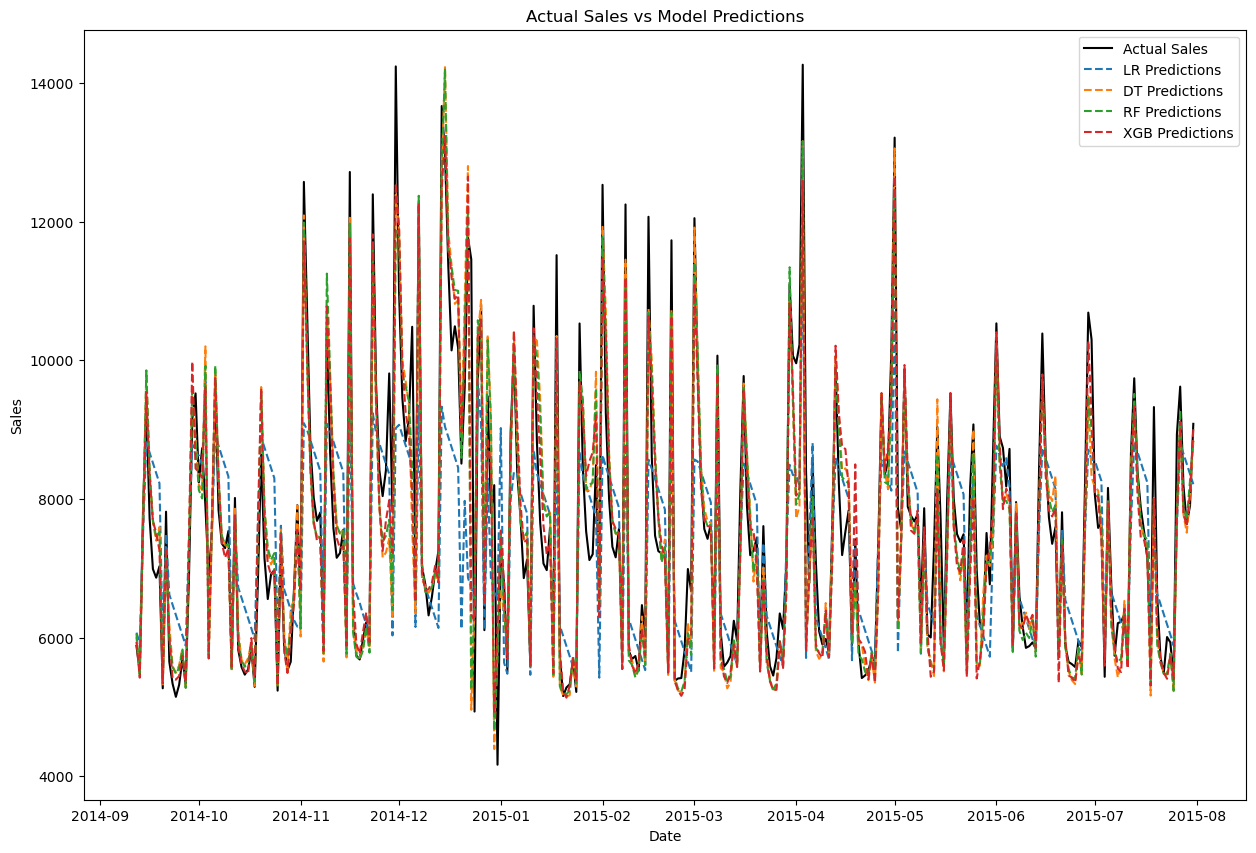

In [258]:
plt.figure(figsize=(15,10))

for column in val_results.columns:
    if column != 'Sales':
        plt.plot(val_results.index, val_results[column], linestyle='--')
    else:
        plt.plot(val_results.index, val_results[column], linestyle='-', color='black')

plt.legend(['Actual Sales', 'LR Predictions', 'DT Predictions', 'RF Predictions', 'XGB Predictions'])
plt.title('Actual Sales vs Model Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [307]:
snapshot = val_results[val_results.index > '2015-06-15'].copy()

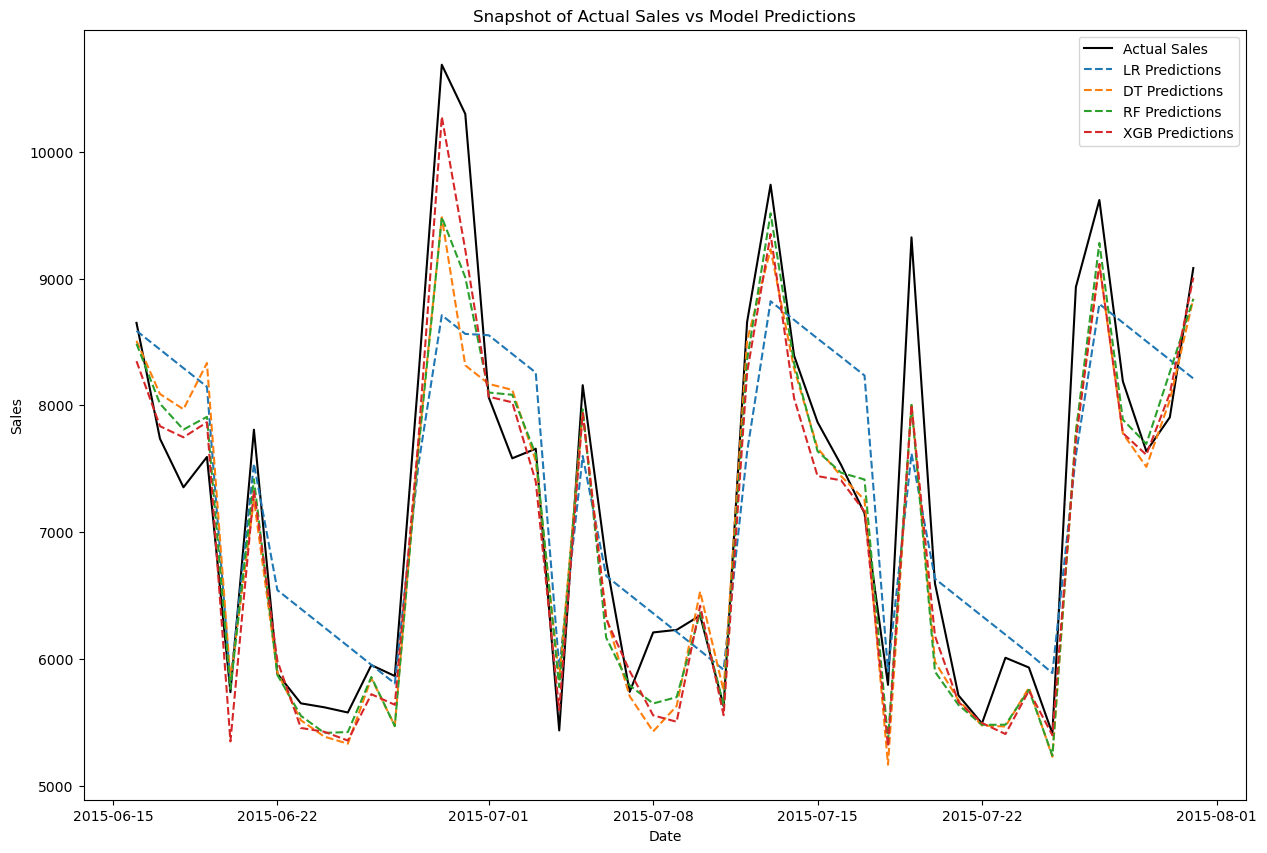

In [308]:
plt.figure(figsize=(15,10))

for column in snapshot.columns:
    if column != 'Sales':
        plt.plot(snapshot.index, snapshot[column], linestyle='--')
    else:
        plt.plot(snapshot.index, snapshot[column], linestyle='-', color='black')

plt.legend(['Actual Sales', 'LR Predictions', 'DT Predictions', 'RF Predictions', 'XGB Predictions'])
plt.title('Snapshot of Actual Sales vs Model Predictions')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.show()